# **Предсказание ключевых точек**

## Загрузка инструментов

In [2]:
import math
import requests
import numpy as np
from collections import OrderedDict
from scipy.spatial import KDTree

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torchvision import models

import cv2
import matplotlib.pyplot as plt

## Построение каркаса позы через ключевые точки

### [Модель Keypoint RCNN](https://arxiv.org/abs/1708.02002?source=post_page---------------------------)

Для создания Human Pose Skeleton можно воспользоваться архитектурой Keypoint RCNN, имплементация которой представлена в библиотеке torchvision.

Модель обучена на наборе данных MS-COCO (Common Objects in Context) с целью обнаружения 17 ключевых точек человеческого тела (нос, глаза, уши, плечи, локти, запястья, бёдра, колени и лодыжки).

Архитектура Keypoint RCNN представлена на рисунке ниже.

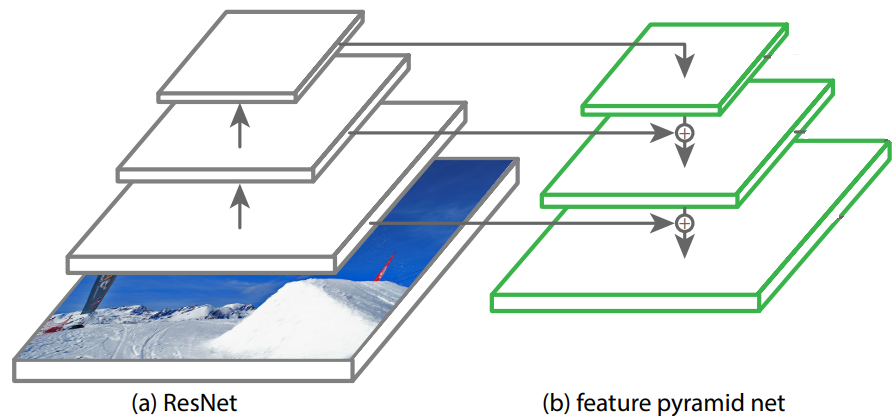

Модель выводит список из следующих элементов:

* boxes — тензор размера [N, 4], где N — количество обнаруженных объектов.
* labels — тензор размера [N], класс объекта. Он всегда равен 1, так как каждый обнаруженный «ящик» указывает на человека. 0 обозначает фоновый класс.
* scores — тензор размера [N], отображающий показатель достоверности обнаруженного объекта.
* keypoints — тензор размера [N, 17, 3], отображающий 17 ключевых точек N человек. Первые два числа — координаты x и y, а третье — видимость.
* keypoints_scores — тензор размера [N, 17], отражающий оценку всех ключевых точек для каждого обнаруженного человека.

### Перенос обучения для построения каркаса спортсмена

Подгрузим предобученный детектор ключевых точек.

In [3]:
keypointrcnn = models.detection.keypointrcnn_resnet50_fpn(weights='COCO_LEGACY')

Возмём список ключевых точек `сoco_keypoints`, например, [отсюда](https://pytorch.org/vision/0.15/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py).

In [4]:
coco_keypoints = [
    'nose','left_eye','right_eye',
    'left_ear','right_ear','left_shoulder',
    'right_shoulder','left_elbow','right_elbow',
    'left_wrist','right_wrist','left_hip',
    'right_hip','left_knee', 'right_knee', 
    'left_ankle','right_ankle'
]

Загрузим и трансформируем изображения.

In [5]:
# URL изображения
# url = ""

# Загрузка изображения по URL
# response = requests.get(url)
# image_data = response.content

# Создание изображения PIL из загруженных данных
# image = Image.open(BytesIO(image_data)).convert('RGB')

# загружаем изображение с opencv 
# img1_path = "mediafiles/running_girl.png"
# img2_path = "mediafiles/running_girls.png"

img1_path = "mediafiles/yoga5-1.jpg"
img2_path = "mediafiles/yoga5-5.jpg"

image1 = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)

print('Размер первого изображения:', image1.shape)
print('Размер второго изображения:', image2.shape)

Размер первого изображения: (801, 1200, 3)
Размер второго изображения: (408, 612, 3)


Если изображения оказались разного размера, то мы можем их обрезать либо дополнить до общего.

In [6]:
# Задаем требуемые размеры
target_size = (612, 408)

def crop_and_pad(image, target_size):
    # Получаем текущий размер изображения
    h, w, _ = image.shape
    
    # Если размер больше заданного, обрезаем
    if (h > target_size[0]) or (w > target_size[1]):
        y_start = (h - target_size[0]) // 2
        x_start = (w - target_size[1]) // 2
        image = image[y_start:y_start + target_size[0], x_start:x_start + target_size[1]]
    else:
        # Если размер меньше заданного, дополняем пустыми областями
        # Создаем изображение с фоном (черным или другим цветом)
        padded_image = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
        
        # Расчет координат размещения оригинального изображения в новом
        y_offset = (target_size[0] - h) // 2
        x_offset = (target_size[1] - w) // 2
        
        # Копируем оригинальное изображение в новое с учетом смещения
        padded_image[y_offset:y_offset + h, x_offset:x_offset + w] = image
        image = padded_image

    return image

# Обрабатываем изображения
# cropped_image1 = crop_and_pad(image1, target_size)
# cropped_image2 = crop_and_pad(image2, target_size)

resized_image1 = cv2.resize(image1, target_size)
resized_image2 = cv2.resize(image2, target_size)

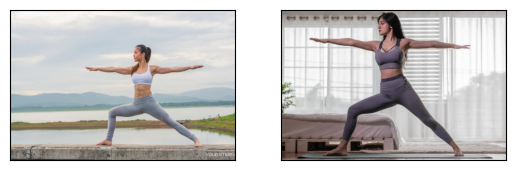

In [7]:
# Определение трансформации
transform = T.Compose([T.ToTensor()])

# Применение трансформации к изображению
tensor_image1 = transform(resized_image1)
tensor_image2 = transform(resized_image2)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    _, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


show([tensor_image1, tensor_image2])

Прогоним изображения через модель для получения ключевых точек.

In [8]:
# Установка модели в режим оценки
keypointrcnn.eval()

# Создание батча из двух изображений
batch_tensor = torch.stack((tensor_image1, tensor_image2), dim=0)

# Прогоняем изображение через модель
with torch.no_grad():
    outputs = keypointrcnn(batch_tensor)

Отрисуем ключевые точки с помощью функции draw_keypoints_per_person:

In [9]:
def draw_keypoints_per_person(
    img, all_keypoints, all_scores, confs, boxes, keypoint_threshold=2, conf_threshold=0.9
):
    # создаем спектр цветов с помощью hsv
    cmap = plt.get_cmap("hsv")
    # создаем копию изображения 
    img_copy = np.array(img.copy())
    # Фильтруем людей по уверенности 
    valid_people = [i for i in range(len(all_keypoints)) if confs[i] > conf_threshold]
    num_people = len(valid_people)
    
    # Генерируем цвета только для людей с достаточной уверенностью
    colors = [tuple(np.asarray(cmap(i / num_people)[:-1]) * 255) for i in range(num_people)]
    
    # для каждого задетектированного человека
    for idx, person_id in enumerate(valid_people):
        # собираем опорные точки конкретного человека 
        keypoints = all_keypoints[person_id, ...]
        scores = all_scores[person_id, ...]
        # Рисуем ограничивающую рамку
        box = boxes[person_id]
        x1, y1, x2, y2 = map(int, box.detach().numpy().tolist())
        box_color = colors[idx]  # Используем цвет для рамки 
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), box_color, 2)  # Рисуем рамку
        
        # итерируем по каждому скору 
        for kp in range(len(scores)):
            # проверяем степень уверенности детектора опорной точки 
            if scores[kp] > keypoint_threshold:
                # конвертируем массив опорных точек в список целых чисел
                keypoint = tuple(map(int, keypoints[kp, :2].detach().numpy().tolist()))
                keypoint_color = colors[idx]  # Используем тот же цвет для ключевой точки 
                # рисуем кружок радиуса 3 вокруг точки
                cv2.circle(img_copy, keypoint, 3, keypoint_color, -1)

    return img_copy

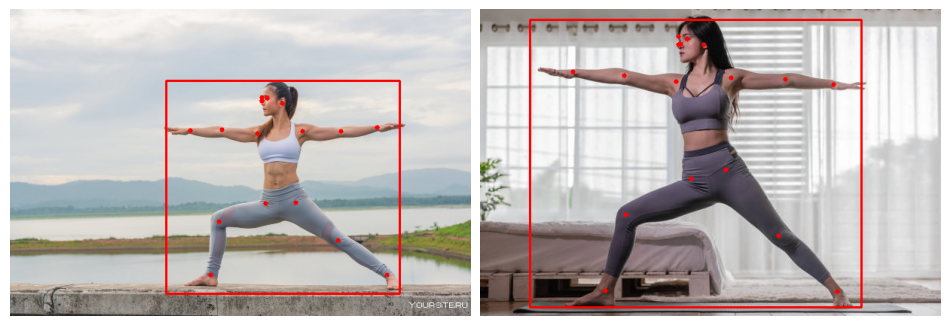

In [10]:
# Извлекаем ключевые точки и уверенности
keypoints1 = outputs[0]['keypoints']
scores1 = outputs[0]['keypoints_scores']
boxes1 = outputs[0]['boxes']
confs1 = outputs[0]['scores']

keypoints2 = outputs[1]['keypoints']
scores2 = outputs[1]['keypoints_scores']
boxes2 = outputs[1]['boxes']
confs2 = outputs[1]['scores']

# Визуализация
result_img1 = draw_keypoints_per_person(
    resized_image1, keypoints1, scores1, confs1, boxes1
    )
result_img2 = draw_keypoints_per_person(
    resized_image2, keypoints2, scores2, confs2, boxes2
    )

# Отображаем результат
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Display the images
ax[0].imshow(result_img1)
ax[1].imshow(result_img2)
# Remove axis ticks
ax[0].axis('off')
ax[1].axis('off')
plt.subplots_adjust(wspace=0.02)
# Show the plot
plt.show()

Используя вспомогательную функцию, создадим список «конечностей» — он нам поможет строить вектора.

In [12]:
def get_limbs_from_keypoints(keypoints):
    limbs = [
        [keypoints.index("right_eye"), keypoints.index("nose")],
        [keypoints.index("right_eye"), keypoints.index("right_ear")],
        [keypoints.index("left_eye"), keypoints.index("nose")],
        [keypoints.index("left_eye"), keypoints.index("left_ear")],
        [keypoints.index("right_shoulder"), keypoints.index("right_elbow")],
        [keypoints.index("right_elbow"), keypoints.index("right_wrist")],
        [keypoints.index("left_shoulder"), keypoints.index("left_elbow")],
        [keypoints.index("left_elbow"), keypoints.index("left_wrist")],
        [keypoints.index("right_hip"), keypoints.index("right_knee")],
        [keypoints.index("right_knee"), keypoints.index("right_ankle")],
        [keypoints.index("left_hip"), keypoints.index("left_knee")],
        [keypoints.index("left_knee"), keypoints.index("left_ankle")],
        [keypoints.index("right_shoulder"), keypoints.index("left_shoulder")],
        [keypoints.index("right_hip"), keypoints.index("left_hip")],
        [keypoints.index("right_shoulder"), keypoints.index("right_hip")],
        [keypoints.index("left_shoulder"), keypoints.index("left_hip")],
    ]
    return limbs

In [13]:
limbs = get_limbs_from_keypoints(coco_keypoints)

Напишем функцию для отрисовки каркаса (скелета) на базе уже имеющейся функции отрисовки ключевых точек.

In [14]:
def draw_skeleton_per_person(img, all_keypoints, all_scores, confs, limbs, boxes, keypoint_threshold=2, conf_threshold=0.9):
    cmap = plt.get_cmap("hsv")
    img_copy = np.array(img.copy())
    points = OrderedDict()
    vectors = []
    vectors_scores = []

    # Фильтрация людей по уверенности
    valid_people = [i for i in range(len(all_keypoints)) if confs[i] > conf_threshold]
    num_people = len(valid_people)
    
    # Генерация цветов только для людей с достаточной уверенностью
    colors = [tuple(np.asarray(cmap(i / num_people)[:-1]) * 255) for i in range(num_people)]

    if len(all_keypoints) > 0:
        for idx, person_id in enumerate(valid_people):
            keypoints = all_keypoints[person_id, ...]
            # Рисуем ограничивающую рамку
            box = boxes[person_id]
            x1, y1, x2, y2 = map(int, box.detach().numpy().tolist())
            box_color = colors[idx]  # Используем цвет для рамки 
            cv2.rectangle(img_copy, (x1, y1), (x2, y2), box_color, 2)  # Рисуем рамку

            for limb_id in range(len(limbs)):
                limb_loc1 = keypoints[limbs[limb_id][0], :2].detach().numpy().astype(np.int32)
                if tuple(limb_loc1) not in points:
                    points[tuple(limb_loc1)] = []
                points[tuple(limb_loc1)].append(limb_id)

                limb_loc2 = keypoints[limbs[limb_id][1], :2].detach().numpy().astype(np.int32)
                if tuple(limb_loc2) not in points:
                    points[tuple(limb_loc2)] = []
                points[tuple(limb_loc2)].append(limb_id)

                vectors.append([list(limb_loc1), list(limb_loc2)])
                score1 = all_scores[person_id, limbs[limb_id][0]].numpy()
                score2 = all_scores[person_id, limbs[limb_id][1]].numpy()
                limb_score = min(score1, score2)
                vectors_scores.append([score1, score2])

                if limb_score > keypoint_threshold:
                    color = colors[idx]  # Используем цвет для линий
                    cv2.line(img_copy, tuple(limb_loc1), tuple(limb_loc2), color, 3)

    return img_copy, points, vectors, vectors_scores

Отрисуем каркас на изображениях по предсказанным ключевым точкам.

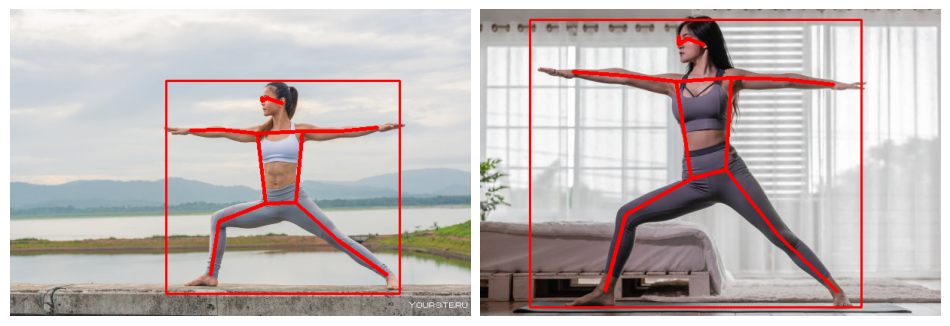

In [34]:
# Визуализация
result_img_with_skeleton1, points1, vectors1, vec_scores1 = draw_skeleton_per_person(
    resized_image1, keypoints1, scores1, confs1, limbs, boxes1,
    keypoint_threshold=2, conf_threshold=0.9
)

result_img_with_skeleton2, points2, vectors2, vec_scores2 = draw_skeleton_per_person(
    resized_image2, keypoints2, scores2, confs2, limbs, boxes2,
    keypoint_threshold=2, conf_threshold=0.9
)

# Отображаем результат
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Display the images
ax[0].imshow(result_img_with_skeleton1)
ax[1].imshow(result_img_with_skeleton2)
# Remove axis ticks
ax[0].axis('off')
ax[1].axis('off')
plt.subplots_adjust(wspace=0.02)
# Show the plot
plt.show()

Отрисуем только вектора.

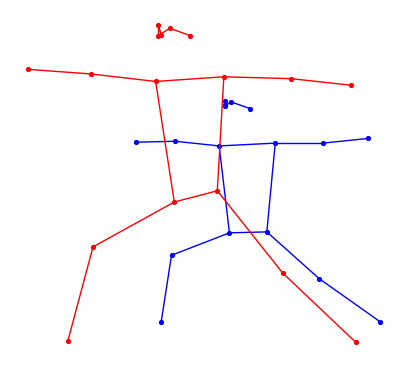

In [16]:
def show_vectors(vectors_list, ax, color='b', marker='.', s=30):
    # Extract nodes and edges
    edges = []
    nodes = set()
    for edge in vectors_list:
        nodes.add(tuple(edge[0]))
        nodes.add(tuple(edge[1]))
        
    for edge in vectors_list:
        edges.append((tuple(edge[0]), tuple(edge[1])))

    # Create a graph
    ax.set_aspect('equal')

    # Draw nodes
    for node in nodes:
        ax.scatter(
            node[0], node[1], c=color,
            marker=marker, s=s
            )

    # Draw edges
    for edge in edges:
        ax.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], c=color, lw=1)


# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(5, 5))

# Отображаем оба набора векторов на одном графике
show_vectors(vectors1, ax)
show_vectors(vectors2, ax, color='r')

# Инвертируем ось Y, если необходимо
ax.invert_yaxis()

# Убираем метки осей
ax.axis('off')

# Показываем результат
plt.show()

Отличный результат!

## Сравнение поз по фотографиям

Первый этап на пути к созданию виртуального коуча пройден! Теперь, когда мы умеем оценивать каркас человека по фото, перейдём к сравнению поз двух людей, выполняющих заданное упражнение, на двух изображениях.

Сравним две позы. Идея в том, что коуч задаёт человеку модельную позу, которую он должен попытаться повторить. После фотографирования решается, соответствует ли входная поза позе коуча.

Итак, у нас есть два набора ключевых точек:

* Модельный набор (который нужно имитировать).
* Ввод (необходимо сопоставить его с модельным набором).

Как же сравнить эти два набора?

Задача сводится к тому, чтобы проверить формы поз на схожесть. Для её решения можно использовать [наложение Прокруста](https://en.wikipedia.org/wiki/Procrustes_analysis), которое выполняется путём оптимального перемещения, вращения и равномерного масштабирования объектов. Другими словами, свободно регулируется как размещение в пространстве, так и размер объектов. Цель состоит в том, чтобы получить аналогичное размещение и размер, минимизируя меру различия формы, называемую прокрустовым расстоянием между объектами.

![Procrustes superimposition](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/Procrustes_superimposition.png/615px-Procrustes_superimposition.png)

> Прокрустово наложение. На рисунке показаны три шага преобразования обычной прокрустовой посадки для двух конфигураций ориентиров. (a) Масштабирование обеих конфигураций до одинакового размера; (b) Транспонирование в одинаковое положение центра тяжести; (c) Вращение в ориентацию, которая обеспечивает минимальную сумму квадратов расстояний между соответствующими ориентирами.

Итак, нам необходима комбинация переноса, масштабирования и поворота, которая лучше всего преобразует исходную позу в позу модели. В линейной алгебре такая комбинация представлена аффинным преобразованием.

Свойства аффинного преобразования:

* линии сопоставляются с линиями;
* параллельные линии остаются параллельными;
* исходный вектор не обязательно отображается в исходный;
* соотношения сохраняются.

### Применение аффинного преобразования к входному изображению

**Аффинное отображение** (преобразование) $f()$ входного вектора $x$ в модельный вектор $y$ выглядит следующим образом:

$$y=f(x)=A*x + b$$

С помощью расширенной матрицы можно умножить вектор $x$ на матрицу $A$ и добавить вектора $b$ за счёт единственного матричного умножения.
Эта расширенная матрица создаётся следующим образом:
1. Дополняем все векторы «1» в конце.
2. Дополняем матрицу строкой нулей внизу.
3. Дополняем матрицу столбцом (вектором переноса) справа и «1» в правом нижнем углу.

In [17]:
# Преобразуем ключи OrderedDict в список уникальных точек
unique_points1 = list(points1.keys())
unique_points2 = list(points2.keys())

# Соберём два набора ключевых точек
Y = np.array(list(unique_points1)) # [[x1,y1],[x2,y2],...]
X = np.array(list(unique_points2)) # [[x1,y1],[x2,y2],...]

В нашем случае $X$ (входная поза) и $Y$ (поза модели) известны и мы хотим найти расширенную матрицу. Используя алгоритм наименьших квадратов (который минимизирует сумму квадратов), мы можем аппроксимировать решение этой линейной системы и найти матрицу аффинного преобразования.

In [18]:
def nearest_neighbors(A, B):
    """
    Находит ближайших соседей для каждого элемента в наборе A из набора B.

    Параметры:
    A (numpy.ndarray): Массив точек, для которых необходимо найти ближайших соседей.
    Размерность (n, d), где n — количество точек, d — размерность пространства.
    B (numpy.ndarray): Массив точек, среди которых ищутся
    ближайшие соседи. Размерность (m, d), где m — количество точек.

    Возвращает:
    numpy.ndarray: Индексы ближайших соседей из B для каждой точки в A. Размерность (n,).
    """
    tree = KDTree(B)
    distances, indices = tree.query(A)
    return indices


def compute_transformation(A, B):
    """
    Вычисляет оптимальное аффинное преобразование (вращение, масштаб и сдвиг) 
    для выравнивания набора точек A с набором точек B.

    Параметры:
    A (numpy.ndarray): Массив исходных точек. Размерность (n, d).
    B (numpy.ndarray): Массив целевых точек. Размерность (n, d).

    Возвращает:
    tuple: Кортеж, содержащий:
        - R (numpy.ndarray): Матрица вращения. Размерность (d, d).
        - t (numpy.ndarray): Вектор сдвига. Размерность (d,).
        - scale (float): Масштабный коэффициент.
    """
    # Центрируем точки
    A_centered = A - np.mean(A, axis=0)
    B_centered = B - np.mean(B, axis=0)

    # Вычисляем матрицу ковариации
    H = A_centered.T @ B_centered 
    
    # SVD разложение 
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T  # Вращение

    # Вычисляем масштаб
    scale = np.sum(S) / np.sum(A_centered ** 2)

    # Вычисляем смещение 
    t = np.mean(B, axis=0) - scale * (R @ np.mean(A, axis=0))

    return R, t, scale


def apply_transformation(A, R, t, scale):
    """
    Применяет аффинное преобразование к набору точек A.

    Параметры:
    A (numpy.ndarray): Массив точек, к которым применяется преобразование. Размерность (n, d).
    R (numpy.ndarray): Матрица вращения. Размерность (d, d).
    t (numpy.ndarray): Вектор сдвига. Размерность (d,).
    scale (float): Масштабный коэффициент.

    Возвращает:
    numpy.ndarray: Преобразованные точки. Размерность (n, d).
    """
    return (A @ R.T) * scale + t


def icp(A, B, max_iterations=100, tolerance=1e-6):
    for i in range(max_iterations):
        indices = nearest_neighbors(A, B)
        B_matched = B[indices]

        R, t, scale = compute_transformation(A, B_matched)

        A_transformed = apply_transformation(A, R, t, scale)

        # Проверка сходимости
        mean_error = np.mean(np.linalg.norm(A_transformed - B_matched, axis=1))
        if mean_error < tolerance:
            break

        A = A_transformed  # Обновляем A для следующей итерации

    return A_transformed


def icp(A, B, max_iterations=100, tolerance=1e-6):
    """
    Реализует алгоритм итеративного ближайшего соседа (ICP)
    для выравнивания набора точек A с набором точек B.

    Параметры:
    A (numpy.ndarray): Исходный массив точек. Размерность (n, d).
    B (numpy.ndarray): Целевой массив точек. Размерность (m, d).
    max_iterations (int, optional): Максимальное количество итераций. По умолчанию 100.
    tolerance (float, optional): Порог сходимости. По умолчанию 1e-6.

    Возвращает:
    numpy.ndarray: Преобразованный массив точек A, выровненный с B. Размерность (n, d).
    """
    for i in range(max_iterations):
        indices = nearest_neighbors(A, B)
        B_matched = B[indices]

        R, t, scale = compute_transformation(A, B_matched)

        A_transformed = apply_transformation(A, R, t, scale)

        # Проверка сходимости
        mean_error = np.mean(np.linalg.norm(A_transformed - B_matched, axis=1))
        if mean_error < tolerance:
            break

        A = A_transformed  # Обновляем A для следующей итерации

    return A_transformed

Отобразим получившийся результат.

In [19]:
def get_transformed_vectors(points, vectors, transformed_points):
    transformed_vectors = []
    points_keys = list(points.keys())

    for idx in range(len(vectors)):
        vector = []
        for i, key in enumerate(points_keys):
            if idx in points[key]:
                vector.append(list(np.round(transformed_points[i]).astype('int32')))
        transformed_vectors.append(vector)
        
    return transformed_vectors

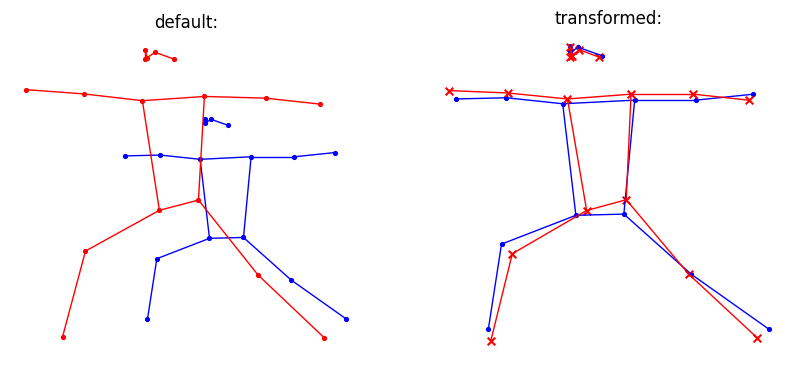

In [35]:
transformed_X = icp(X, Y)

transformed_vectors2 = get_transformed_vectors(points2, vectors2, transformed_X)

# Визуализация исходных и преобразованных данных
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

show_vectors(vectors1, ax[0])
show_vectors(vectors2, ax[0], color='r')

show_vectors(vectors1, ax[1])
show_vectors(transformed_vectors2, ax[1], color='r', marker='x')

# Настройки графика
ax[0].set_title('default:')
ax[1].set_title('transformed:')
ax[0].axis('off')
ax[1].axis('off')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
plt.show()

Итак, при сравнении поз на двух картинках стоит учитывать, что изображения могут иметь разный размер, человек может появиться в разных местах фотографии и т. д. С помощью аффинного отображения мы получили преобразованный набор ключевых точек, необходимый для корректного сравнения поз. Пришло время перейти к оценке их сходства.

### Косинусное сходство и взвешенное совпадение

Теперь, когда у нас есть преобразованный вход X, мы можем сравнить его с позой модели. Для определения «сходства» X и Y можно воспользоваться косинусным сходством и взвешенным совпадением с учётом показателей достоверности ключевых точек.

In [22]:
def cossim(vectors1, vectors2):
    # Функция для вычисления косинусного сходства
    def cosine_similarity(a, b):
        dot_product = np.dot(a, b)
        norm_a = np.linalg.norm(a)
        norm_b = np.linalg.norm(b)
        return dot_product / (norm_a * norm_b) if norm_a != 0 and norm_b != 0 else 0

    # Основной процесс
    similarities = []
    shifted_vecs1, shifted_vecs2 = [], []
    for vec1, vec2 in zip(vectors1, vectors2):
        # Вычисление центра первой фигуры
        center1 = np.mean(vec1, axis=0)
        
        # Вычисление центра второй фигуры
        center2 = np.mean(vec2, axis=0)
        
        # Перенос векторов в начало координат
        shifted_vec1 = np.array(vec1) - center1
        shifted_vec2 = np.array(vec2) - center2
        
        shifted_vecs1.append(shifted_vec1)
        shifted_vecs2.append(shifted_vec2)
        
        # Преобразуем векторы в одномерные массивы для косинусного сходства
        flat_vec1 = shifted_vec1.flatten()
        flat_vec2 = shifted_vec2.flatten()

        # Вычисление косинусного сходства
        sim = cosine_similarity(flat_vec1, flat_vec2)
        similarities.append(sim)
        
    mean_cossim = np.mean(similarities)
    
    return mean_cossim, similarities, shifted_vecs1, shifted_vecs2


def weight_similarity(pose1, pose2, conf1):
    flat_pose1 = np.array(pose1).flatten()
    flat_pose2 = np.array(pose2).flatten()
    flat_conf1 = np.array(conf1).flatten()
    
    # Нормализация поз
    norm1 = np.linalg.norm(flat_pose1)
    norm2 = np.linalg.norm(flat_pose2)

    # Если любая из норм равна 0, возвращаем 0
    if norm1 == 0 or norm2 == 0:
        return 0

    # Нормализуем позы
    pose1_normalized = flat_pose1 / norm1
    pose2_normalized = flat_pose2 / norm2
    
    # D(U,V) = (1 / sum(conf1)) * sum(conf1 * ||pose1 - pose2||) = sum1 * sum2
    # Вычисление взвешенного расстояния
    sum1 = 1 / np.sum(flat_conf1)
    sum2 = 0

    for i in range(len(pose1_normalized)):
        conf_ind = math.floor(i / 2)  # Предполагаем, что каждая точка отвечает одной оценке достоверности
        sum2 += flat_conf1[conf_ind] * abs(pose1_normalized[i] - pose2_normalized[i])

    weighted_distance = sum1 * sum2

    # Вычисляем взвешенную схожесть (переводим в диапазон от 0 до 1)
    # Сначала проверим, что расстояние не превышает 1
    similarity = max(0, 1 - weighted_distance)

    return similarity

In [23]:
# Вычисление косинусного сходства
mean_cossim, similarities, shifted_vecs1, shifted_vecs2 = cossim(
    vectors1, transformed_vectors2
    )

# Вывод результатов
for i, sim in enumerate(similarities):
    print(f"Косинусное сходство для {i+1}-векторов: {sim:.4f}")
    
print(f'\nСреднее косинусное сходство:\t{mean_cossim:.4f}')

weighted_similarity = weight_similarity(
    shifted_vecs1, shifted_vecs2, vec_scores1
    )

# Вывод результатов
print(f'Взвешенное сходство:\t\t{weighted_similarity:.4f}')

print(f'Среднee сходство:\t\t{(weighted_similarity + mean_cossim)/2:.4f}')

Косинусное сходство для 1-векторов: 1.0000
Косинусное сходство для 2-векторов: 0.9615
Косинусное сходство для 3-векторов: -0.9923
Косинусное сходство для 4-векторов: 0.9998
Косинусное сходство для 5-векторов: 1.0000
Косинусное сходство для 6-векторов: 0.9979
Косинусное сходство для 7-векторов: 1.0000
Косинусное сходство для 8-векторов: 0.9776
Косинусное сходство для 9-векторов: 0.9877
Косинусное сходство для 10-векторов: 0.9961
Косинусное сходство для 11-векторов: 0.9896
Косинусное сходство для 12-векторов: 0.9911
Косинусное сходство для 13-векторов: 0.9997
Косинусное сходство для 14-векторов: 0.9710
Косинусное сходство для 15-векторов: 0.9986
Косинусное сходство для 16-векторов: 0.9988

Среднее косинусное сходство:	0.8673
Взвешенное сходство:		0.9706
Среднee сходство:		0.9190


Подведём итог. Благодаря алгоритмам сходства, таким как косинусное сходство и взвешенное совпадение, мы можем анализировать близость между двумя оценками позы человека. Сходство косинуса рассчитывается путём создания векторов поз и оценки косинуса угла между ними. Взвешенное совпадение учитывают оценку достоверности каждой отдельно найденной ключевой точки так, чтобы более реалистичные ключевые точки в большей степени влияли на результат.